# インストール

In [1]:
!pip install japanize-matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 27.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=2d8237f30bd33e0d6613e9fdb308b6eddc442fce5a99276b9c6e2191f4963d03
  Stored in directory: /root/.cache/pip/wheels/91/8f/c2/83055ad0c9591b0a094730aa7cb2cc12fedacbcd2241baf534
Successfully built japanize-matplotlib


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import collections
import copy
import os
from collections import defaultdict
import numpy as np
import torch
import csv
from tqdm import tqdm
import itertools
import japanize_matplotlib
import seaborn as sns
import pprint

sns.set(font='IPAexGothic')
from itertools import chain

# 【① 周辺文脈が多様】 エンティティとエンティティ以外のクラスタの分離度合い

## Results

In [4]:
path = "./result/bert-base-uncased/VariousContext/cluster_ratio_lastLayer.jsonl"
various_context_df = pd.read_json(path, orient="records", lines=True)
display(various_context_df)

,target_word,notable_figer_types,percentage_of_own_cluster,own_count_list,sentence_count,wrong_cluster,wrong_types,wiki_id,word_type,target_word_sub_len
0,Barbara Boxer,/person/politician,1.000000,86,86,{},{},http://en.wikipedia.org/wiki/Barbara_Boxer,ne,2.0
1,Richard Egan,/person/actor,1.000000,12,12,{},{},http://en.wikipedia.org/wiki/Richard_Egan_(actor),ne,2.0
2,Norm Macdonald,/person/author,1.000000,14,14,{},{},http://en.wikipedia.org/wiki/Norm_Macdonald_(c...,ne,2.0
3,Fritz Kreisler,/person/musician,1.000000,39,39,{},{},http://en.wikipedia.org/wiki/Fritz_Kreisler,ne,5.0
4,Michael Mann,/person/director,1.000000,59,59,{},{},http://en.wikipedia.org/wiki/Michael_Mann_(dir...,ne,2.0
...,...,...,...,...,...,...,...,...,...,...
7927,1909,None,1.000000,35,35,{},{},None,non_ne,NaN
7928,drinking,None,1.000000,62,62,{},{},None,non_ne,NaN
7929,deny,None,1.000000,13,13,{},{},None,non_ne,NaN
7930,pace,None,1.000000,20,20,{},{},None,non_ne,NaN


In [5]:
##　　エンティティクラスタの分離度合い （凝縮率=100%のクラスタの割合）
various_context_ne_df = various_context_df[various_context_df['word_type']=='ne']
various_context_ne_df = various_context_ne_df.sort_values(by="wiki_id").reset_index(drop=True)
display(various_context_ne_df)

print(f"NE Percentage　of 100% : {sum(list(various_context_ne_df['percentage_of_own_cluster']==1)) / len(various_context_ne_df)}")

,target_word,notable_figer_types,percentage_of_own_cluster,own_count_list,sentence_count,wrong_cluster,wrong_types,wiki_id,word_type,target_word_sub_len
0,Aaron Rose,/person/director,1.0,25,25,{},{},http://en.wikipedia.org/wiki/Aaron_Rose,ne,2.0
1,"Abdera, Thrace",/location/city,0.9,9,10,{'existing': 1},{'Non_NE': 1},"http://en.wikipedia.org/wiki/Abdera,_Thrace",ne,5.0
2,Adam Ferguson,/person/author,1.0,12,12,{},{},http://en.wikipedia.org/wiki/Adam_Ferguson,ne,2.0
3,Al Schmitt,/person/artist,1.0,10,10,{},{},http://en.wikipedia.org/wiki/Al_Schmitt,ne,4.0
4,Alan Page,/person/athlete,1.0,17,17,{},{},http://en.wikipedia.org/wiki/Alan_Page,ne,2.0
...,...,...,...,...,...,...,...,...,...,...
362,"Windsor, Ontario",/location/city,1.0,13,13,{},{},"http://en.wikipedia.org/wiki/Windsor,_Ontario",ne,3.0
363,Wisin & Yandel,/person/artist,1.0,10,10,{},{},http://en.wikipedia.org/wiki/Wisin_&_Yandel,ne,5.0
364,Xalapa,/location/city,1.0,11,11,{},{},http://en.wikipedia.org/wiki/Xalapa,ne,3.0
365,Yael Bartana,/person/artist,1.0,10,10,{},{},http://en.wikipedia.org/wiki/Yael_Bartana,ne,4.0


NE Percentage　of 100% : 0.8419618528610354


In [6]:
##　　エンティティ以外のクラスタの分離度合い （凝縮率=100%のクラスタの割合）
various_context_nonNe_df = various_context_df[various_context_df['word_type']=='non_ne']
display(various_context_nonNe_df)


print(f"Non NE Percentage　of 100% : {sum(list(various_context_nonNe_df['percentage_of_own_cluster']==1)) / len(various_context_nonNe_df)}")

,target_word,notable_figer_types,percentage_of_own_cluster,own_count_list,sentence_count,wrong_cluster,wrong_types,wiki_id,word_type,target_word_sub_len
367,traded,None,0.909091,20,22,"{'trading': 1, 'trade': 1}",{'Non_NE': 2},None,non_ne,NaN
368,integrity,None,1.000000,15,15,{},{},None,non_ne,NaN
369,traders,None,1.000000,19,19,{},{},None,non_ne,NaN
370,destruction,None,0.952381,60,63,"{'damage': 1, 'devastation': 1, 'reconstructed...",{'Non_NE': 3},None,non_ne,NaN
371,magnitude,None,0.916667,11,12,{'overwhelming': 1},{'Non_NE': 1},None,non_ne,NaN
...,...,...,...,...,...,...,...,...,...,...
7927,1909,None,1.000000,35,35,{},{},None,non_ne,NaN
7928,drinking,None,1.000000,62,62,{},{},None,non_ne,NaN
7929,deny,None,1.000000,13,13,{},{},None,non_ne,NaN
7930,pace,None,1.000000,20,20,{},{},None,non_ne,NaN


Non NE Percentage　of 100% : 0.5430270984798414


## Plot

percentage_of_own_cluster,"(0.0, 0.9]","(0.9, 0.95]","(0.95, 0.99999999]","(0.99999999, 1.0]"
word_type,,,,
ne,12,16,30,309
non_ne,503,953,2001,4108


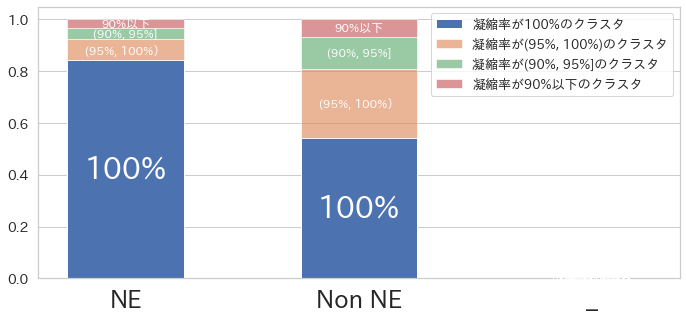

In [11]:
sns.set()
sns.set_style('whitegrid')
japanize_matplotlib.japanize()

bins = [0, 0.9, 0.95, 0.99999999,1]
groups = various_context_df.groupby(['word_type', pd.cut(various_context_df.percentage_of_own_cluster, bins)])
display(groups.size().unstack())

plot_df = groups.size().unstack()
# 正規化する
plot_df = plot_df.div(plot_df.sum(axis=1), axis=0)

plot_df = plot_df.reindex(columns=plot_df.columns[::-1])


column_labels = ['100%', '(95%, 100%）',  '(90%, 95%]', '90%以下' ]
legend_labels = ['凝縮率が100%のクラスタ', '凝縮率が(95%, 100%)のクラスタ',  '凝縮率が(90%, 95%]のクラスタ', '凝縮率が90%以下のクラスタ' ]
plot_df = pd.concat([plot_df, pd.DataFrame([[0,0,0,0]], columns=plot_df.columns, index=['dummy'])], axis=0)
row_labels = plot_df.index

n_rows, n_cols = plot_df.shape
positions = np.arange(n_rows)
positions = [0,1,2]
offsets = np.zeros(n_rows, dtype=plot_df.values.dtype)

fig, ax = plt.subplots(figsize=(11.5,5))
ax.set_xticks(positions, fontsize=14)
ax.set_xticklabels(["NE", "Non NE", "_"], fontsize=24)
plt.yticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.tick_params(labelbottom=False)
ax.grid(axis="x")

for i in range(len(plot_df.columns)):
    # 棒グラフを描画する。
    #bar = ax.bar(positions, plot_df.iloc[:, i], bottom=offsets, color=colors[i], width=0.4, align="center")
    if i==0:
      alpha=1
      fontsize=30
    else:
      alpha=0.6
      fontsize=12
    bar = ax.bar(positions, plot_df.iloc[:, i], bottom=offsets,  width=0.5, align="center", label=legend_labels[i], alpha=alpha)
    offsets += plot_df.iloc[:, i]

    # 棒グラフのラベルを描画する。
    for rect in bar:
        cx = rect.get_x() + rect.get_width() / 2
        cy = rect.get_y() + rect.get_height() / 2
        ax.text(cx, cy, column_labels[i], color="w", ha="center", va="center", fontsize=fontsize)

ax.legend(loc="best", fontsize=13)



# 【② 周辺文脈とメンションが多様】 エンティティとエンティティ以外のクラスタの分離度合い

## Results

In [12]:
path = "./result/bert-base-uncased/VariousContextMention/cluster_ratio_lastLayer.jsonl"

various_contextMention_df = pd.read_json(path, orient='records', lines=True)
display(various_contextMention_df)

,target_word,notable_figer_types,percentage_of_own_cluster,own_count_list,sentence_count,wrong_cluster,wrong_types,wiki_id,word_type,alias_count,wrong_pair
0,"[Narmada River, Ilug Narmada, Narmada River, N...",[/location/body_of_water],0.923077,12,13,{'Kinnaur': 1},{'/location/county': 1},http://en.wikipedia.org/wiki/Narmada_River,ne,5.0,{'Ilug Narmada : Kinnaur': 1}
1,"[South Africa, South Africa, South Africa, Sou...",[/location/country],0.980392,1050,1071,"{'south': 11, 'subcontinent': 1, 'beach': 1, '...","{'Non_NE': 15, '/location/city': 3, '/person/m...",http://en.wikipedia.org/wiki/South_Africa,ne,8.0,"{'South Africa : south': 11, 'South Africa : s..."
2,"[Goldberg, Goldberg, Bill Goldberg, Bill Goldb...",[/person/actor],1.000000,26,26,{},{},http://en.wikipedia.org/wiki/Bill_Goldberg,ne,2.0,{}
3,"[Czech, Czech Republic, Czech Republic, Czech ...",[/location/country],0.971253,1892,1948,"{'base': 2, 'rail': 8, 'company': 1, 'outdoor'...","{'Non_NE': 34, '/person/musician': 17, '/perso...",http://en.wikipedia.org/wiki/Czech_Republic,ne,12.0,"{'en:Czech Republic : base': 2, 'Czech Republi..."
4,"[Tony Shafrazi, Tony Shafrazi, Tony Shafrazi, ...",[/person/artist],1.000000,10,10,{},{},http://en.wikipedia.org/wiki/Tony_Shafrazi,ne,1.0,{}
...,...,...,...,...,...,...,...,...,...,...,...
7927,"[1909, 1909, 1909, 1909, 1909, 1909, 1909, 190...",None,1.000000,35,35,{},{},None,non_ne,NaN,{}
7928,"[drinking, drinking, drinking, drinking, drink...",None,1.000000,62,62,{},{},None,non_ne,NaN,{}
7929,"[deny, deny, deny, deny, deny, deny, deny, den...",None,1.000000,13,13,{},{},None,non_ne,NaN,{}
7930,"[pace, pace, pace, pace, pace, pace, pace, pac...",None,1.000000,20,20,{},{},None,non_ne,NaN,{}


In [14]:
##　　エンティティクラスタの分離度合い （凝縮率=100%のクラスタの割合）
various_contextMention_ne_df = various_contextMention_df[various_contextMention_df['word_type']=='ne']
various_contextMention_ne_df = various_contextMention_ne_df.sort_values(by="wiki_id").reset_index(drop=True)
display(various_contextMention_ne_df)


print(f"NE Percentage　of 100% : {sum(list(various_contextMention_ne_df['percentage_of_own_cluster']==1)) / len(various_contextMention_ne_df)}")

,target_word,notable_figer_types,percentage_of_own_cluster,own_count_list,sentence_count,wrong_cluster,wrong_types,wiki_id,word_type,alias_count,wrong_pair
0,"[Aaron Rose, Aaron, Aaron Rose, Aaron Rose, Aa...",[/person/director],1.0,25,25,{},{},http://en.wikipedia.org/wiki/Aaron_Rose,ne,3.0,{}
1,"[Abdera, Abdera, Abdera, Abdera, Thrace, Abder...",[/location/city],0.9,9,10,{'existing': 1},{'Non_NE': 1},"http://en.wikipedia.org/wiki/Abdera,_Thrace",ne,2.0,"{'Abdera, Thrace : existing': 1}"
2,"[Adam Ferguson, Adam Ferguson, Adam Ferguson, ...",[/person/author],1.0,12,12,{},{},http://en.wikipedia.org/wiki/Adam_Ferguson,ne,2.0,{}
3,"[Al Schmitt, Al Schmitt, Al Schmitt, Al Schmid...",[/person/artist],1.0,10,10,{},{},http://en.wikipedia.org/wiki/Al_Schmitt,ne,2.0,{}
4,[Alan Page is now a Minnesota Supreme Court Ju...,[/person/athlete],1.0,17,17,{},{},http://en.wikipedia.org/wiki/Alan_Page,ne,6.0,{}
...,...,...,...,...,...,...,...,...,...,...,...
362,"[Windsor, Windsor, Windsor, Windsor, Windsor, ...",[/location/city],1.0,13,13,{},{},"http://en.wikipedia.org/wiki/Windsor,_Ontario",ne,2.0,{}
363,"[Wisin & Yandel, Wisin &amp; Yandel - Wikipedi...",[/person/artist],1.0,10,10,{},{},http://en.wikipedia.org/wiki/Wisin_&_Yandel,ne,3.0,{}
364,"[Xalapa, Xalapa, Xalapa, Xalapa, Xalapa, Xalap...",[/location/city],1.0,11,11,{},{},http://en.wikipedia.org/wiki/Xalapa,ne,1.0,{}
365,"[Yael Bartana, Yael Bartana, Yael Bartana, Yae...",[/person/artist],1.0,10,10,{},{},http://en.wikipedia.org/wiki/Yael_Bartana,ne,1.0,{}


NE Percentage　of 100% : 0.7166212534059946


In [15]:
##　　エンティティ以外のクラスタの分離度合い （凝縮率=100%のクラスタの割合）
various_contextMention_nonNe_df = various_contextMention_df[various_contextMention_df['word_type']=='non_ne']
display(various_contextMention_nonNe_df)


print(f"Non NE Percentage　of 100% : {sum(list(various_contextMention_nonNe_df['percentage_of_own_cluster']==1)) / len(various_contextMention_nonNe_df)}")

,target_word,notable_figer_types,percentage_of_own_cluster,own_count_list,sentence_count,wrong_cluster,wrong_types,wiki_id,word_type,alias_count,wrong_pair
367,"[traded, traded, traded, traded, traded, trade...",None,0.909091,20,22,"{'trading': 1, 'trade': 1}",{'Non_NE': 2},None,non_ne,NaN,"{'traded : trading': 1, 'traded : trade': 1}"
368,"[integrity, integrity, integrity, integrity, i...",None,1.000000,15,15,{},{},None,non_ne,NaN,{}
369,"[traders, traders, traders, traders, traders, ...",None,1.000000,19,19,{},{},None,non_ne,NaN,{}
370,"[destruction, destruction, destruction, destru...",None,0.952381,60,63,"{'damage': 1, 'devastation': 1, 'reconstructed...",{'Non_NE': 3},None,non_ne,NaN,"{'destruction : damage': 1, 'destruction : dev..."
371,"[magnitude, magnitude, magnitude, magnitude, m...",None,0.916667,11,12,{'overwhelming': 1},{'Non_NE': 1},None,non_ne,NaN,{'magnitude : overwhelming': 1}
...,...,...,...,...,...,...,...,...,...,...,...
7927,"[1909, 1909, 1909, 1909, 1909, 1909, 1909, 190...",None,1.000000,35,35,{},{},None,non_ne,NaN,{}
7928,"[drinking, drinking, drinking, drinking, drink...",None,1.000000,62,62,{},{},None,non_ne,NaN,{}
7929,"[deny, deny, deny, deny, deny, deny, deny, den...",None,1.000000,13,13,{},{},None,non_ne,NaN,{}
7930,"[pace, pace, pace, pace, pace, pace, pace, pac...",None,1.000000,20,20,{},{},None,non_ne,NaN,{}


Non NE Percentage　of 100% : 0.5428949107732981


## Plot

percentage_of_own_cluster,"(0.0, 0.9]","(0.9, 0.95]","(0.95, 0.99999999]","(0.99999999, 1.0]"
word_type,,,,
ne,22,29,53,263
non_ne,503,953,2002,4107


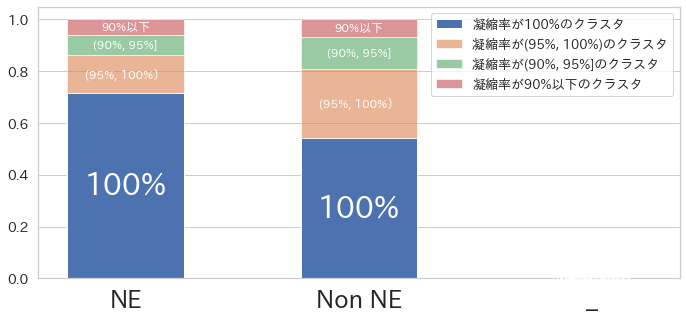

In [18]:
sns.set()
sns.set_style('whitegrid')
japanize_matplotlib.japanize()

bins = [0, 0.9, 0.95, 0.99999999,1]
groups = various_contextMention_df.groupby(['word_type', pd.cut(various_contextMention_df.percentage_of_own_cluster, bins)])
display(groups.size().unstack())

plot_df = groups.size().unstack()
# 正規化する
plot_df = plot_df.div(plot_df.sum(axis=1), axis=0)

plot_df = plot_df.reindex(columns=plot_df.columns[::-1])


column_labels = ['100%', '(95%, 100%）',  '(90%, 95%]', '90%以下' ]
legend_labels = ['凝縮率が100%のクラスタ', '凝縮率が(95%, 100%)のクラスタ',  '凝縮率が(90%, 95%]のクラスタ', '凝縮率が90%以下のクラスタ' ]
plot_df = pd.concat([plot_df, pd.DataFrame([[0,0,0,0]], columns=plot_df.columns, index=['dummy'])], axis=0)
row_labels = plot_df.index

n_rows, n_cols = plot_df.shape
positions = np.arange(n_rows)
positions = [0,1,2]
offsets = np.zeros(n_rows, dtype=plot_df.values.dtype)

fig, ax = plt.subplots(figsize=(11.5,5))
ax.set_xticks(positions, fontsize=14)
ax.set_xticklabels(["NE", "Non NE", "_"], fontsize=24)
plt.yticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.tick_params(labelbottom=False)
ax.grid(axis="x")

for i in range(len(plot_df.columns)):
    # 棒グラフを描画する。
    #bar = ax.bar(positions, plot_df.iloc[:, i], bottom=offsets, color=colors[i], width=0.4, align="center")
    if i==0:
      alpha=1
      fontsize=30
    else:
      alpha=0.6
      fontsize=12
    bar = ax.bar(positions, plot_df.iloc[:, i], bottom=offsets,  width=0.5, align="center", label=legend_labels[i], alpha=alpha)
    offsets += plot_df.iloc[:, i]

    # 棒グラフのラベルを描画する。
    for rect in bar:
        cx = rect.get_x() + rect.get_width() / 2
        cy = rect.get_y() + rect.get_height() / 2
        ax.text(cx, cy, column_labels[i], color="w", ha="center", va="center", fontsize=fontsize)

ax.legend(loc="best", fontsize=13)

